# Imports

In [110]:
import glob
import cv2
import os

import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [111]:
print(os.listdir("../input/intel-mobileodt-cervical-cancer-screening"))

['additional_Type_2_v2', 'test_stg2.7z', 'fixed_labels_v2.csv', 'train', 'sample_submission.csv', 'test', 'additional_Type_1_v2', 'sample_submission_stg2.csv', 'test_stg2_7z_password.txt', 'additional_Type_3_v2', 'removed_files.csv', 'solution_stg1_release.csv']


# Data import

In [112]:
#getting the total number of images in the training set

base_dir = '../input/intel-mobileodt-cervical-cancer-screening'

train_dir = os.path.join(base_dir,'train', 'train')

type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(base_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(base_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(base_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')

type1_files = type1_files + added_type1_files
type2_files = type2_files + added_type2_files
type3_files = type3_files + added_type3_files


print('Number of images in a train set of type 1: ', len(type1_files))
print('Number of images in a train set of type 2: ', len(type2_files))
print('Number of images in a train set of type 3: ', len(type3_files))
print('Total number of images in a train set: ', sum([len(type1_files), len(type2_files), len(type3_files)]))

Number of images in a train set of type 1:  1191
Number of images in a train set of type 2:  3567
Number of images in a train set of type 3:  1976
Total number of images in a train set:  6734


In [113]:
# Building a dataframe mapping images and Cancer type

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
})

files_df

,filename,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
2,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
4,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
...,...,...
6729,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6730,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6731,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6732,../input/intel-mobileodt-cervical-cancer-scree...,Type_3


In [114]:
#Shuffle data

random_state = 42

files_df = files_df.sample(frac=1, random_state=random_state)

files_df

,filename,label
381,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
4696,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
5577,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
2018,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
2185,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
...,...,...
3772,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
5191,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
5226,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
5390,../input/intel-mobileodt-cervical-cancer-scree...,Type_3


# Data exploration

In [115]:
files_df.describe()

,filename,label
count,6734,6734
unique,6734,3
top,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
freq,1,3567


In [116]:
#Check for duplicates
len(files_df[files_df.duplicated()])

0

In [117]:
#Get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts())
type_count

,count
label,
Type_2,3567
Type_3,1976
Type_1,1191


In [118]:
print(list(type_count.columns)[0])

count


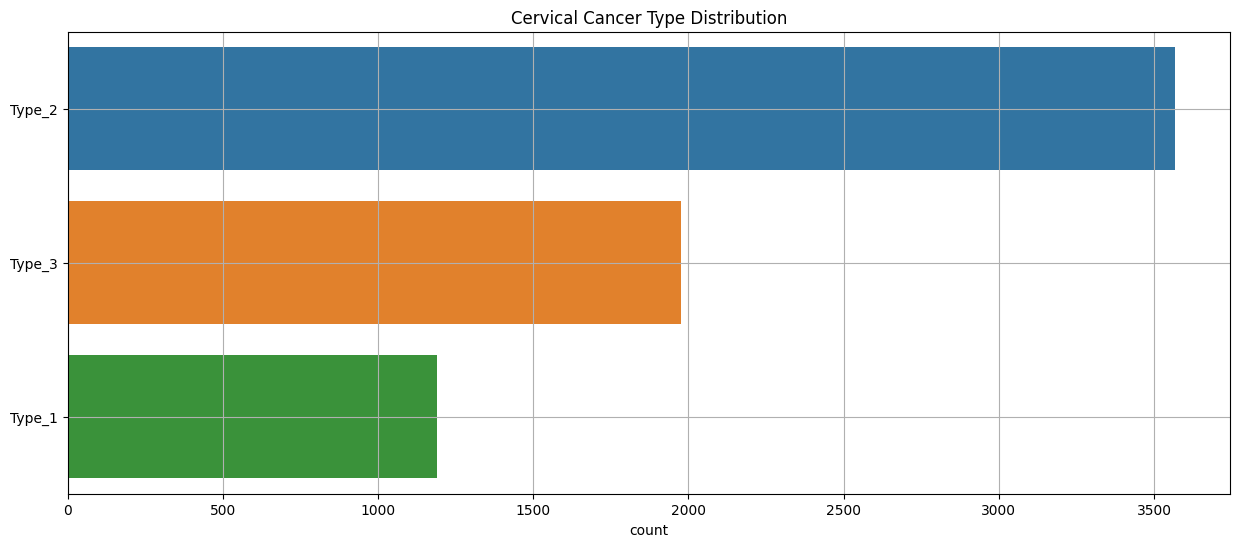

In [119]:
# Display barplot of type count

plt.figure(figsize = (15, 6))
sns.barplot(x= type_count[list(type_count.columns)[0]], y= type_count.index.to_list())
plt.title('Cervical Cancer Type Distribution')
plt.grid(True)
plt.show()

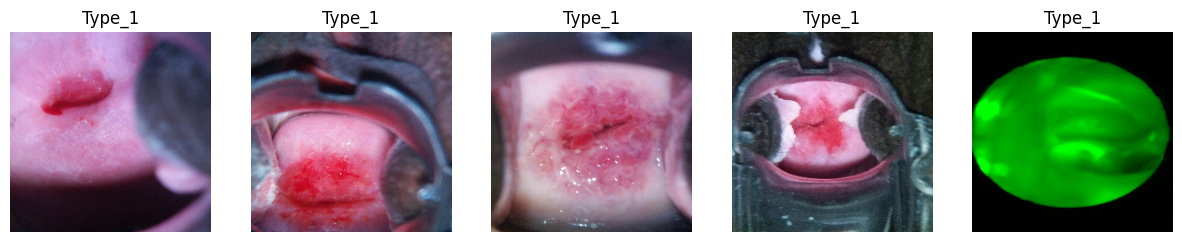

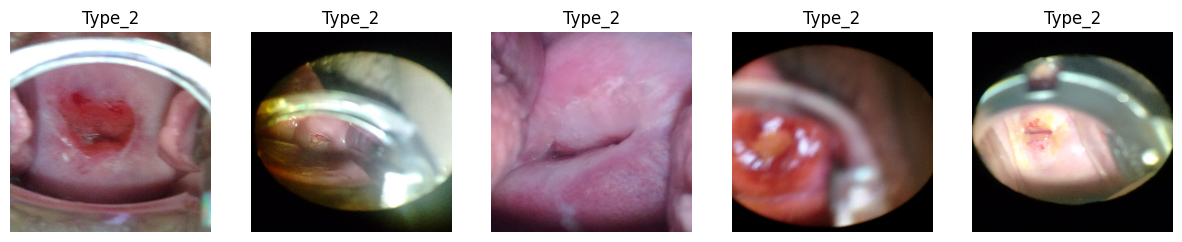

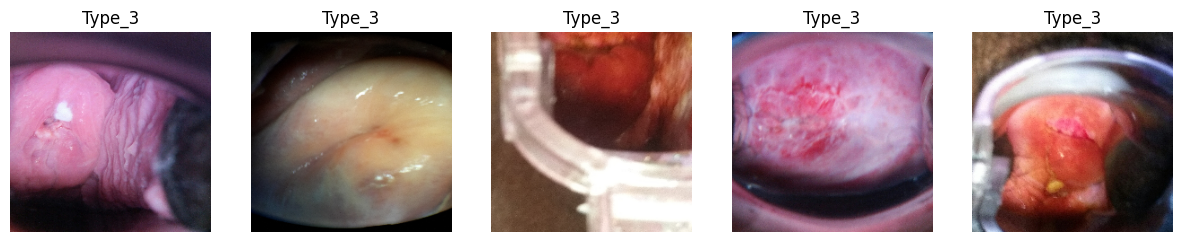

In [120]:
# Display sample images of types
for label in ('Type_1', 'Type_2', 'Type_3'):
    filepaths = files_df[files_df['label']==label]['filename'].values[:5]
    fig = plt.figure(figsize= (15, 6))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (224, 224))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(label)

# Data propocessing

In [121]:
# Split training,val and test set : 70:15:15

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, 
                                                                      random_state=random_state)

test_files, val_files, test_labels, val_labels = train_test_split(test_files,
                                                                  test_labels, 
                                                                  test_size=0.5, 
                                                                  random_state=random_state)


print('Number of images in train set: ', train_files.shape)
print('Number of images in validation set: ', val_files.shape)
print('Number of images in test set: ', test_files.shape, '\n')

print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

Number of images in train set:  (4713,)
Number of images in validation set:  (1011,)
Number of images in test set:  (1010,) 

Train: Counter({'Type_2': 2532, 'Type_3': 1339, 'Type_1': 842}) 
Val: Counter({'Type_2': 529, 'Type_3': 321, 'Type_1': 161}) 
Test: Counter({'Type_2': 506, 'Type_3': 316, 'Type_1': 188})


In [122]:
def load_images(files, labels):
    features = []
    correct_labels = []
    bad_images = 0
    
    for i in range(len(files)):
        try:
            img = cv2.imread(files[i])
            resized_img = cv2.resize(img, (160, 160))
            
            features.append(np.array(resized_img))
            correct_labels.append(labels[i])
                   
        except Exception as e:
            bad_images+=1
            print('Encoutered bad image')
    print('Bad images ecountered:', bad_images)
    return np.array(features), np.array(correct_labels)

In [123]:
# Load training and evaluation data
train_features, train_labels = load_images(train_files, train_labels)
print('Train images loaded')

val_features, val_labels = load_images(val_files, val_labels)
print('Validation images loaded')

test_features, test_labels = load_images(test_files, test_labels)
print('test images loaded')

Premature end of JPEG file


Encoutered bad image
Encoutered bad image
Bad images ecountered: 2
Train images loaded


Premature end of JPEG file


Encoutered bad image
Bad images ecountered: 1
Validation images loaded
Bad images ecountered: 0
test images loaded


In [124]:
# check lengths of training and evaluation  sets
len(train_features), len(train_labels), len(val_features), len(val_labels), len(test_features), len(test_labels) 

(4711, 4711, 1010, 1010, 1010, 1010)

In [125]:
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 10
INPUT_SHAPE = (160, 160, 3)

In [126]:
# encode train+val sets text categories with labels
le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = tf.keras.utils.to_categorical(train_labels_enc, num_classes=NUM_CLASSES)
val_labels_1hotenc = tf.keras.utils.to_categorical(val_labels_enc, num_classes=NUM_CLASSES)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])

['Type_2' 'Type_2' 'Type_2' 'Type_3' 'Type_2' 'Type_1'] [1 1 1 2 1 0]
['Type_2' 'Type_2' 'Type_2' 'Type_3' 'Type_2' 'Type_1'] [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [127]:

le = LabelEncoder()
le.fit(test_labels)

test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = tf.keras.utils.to_categorical(test_labels_enc, num_classes=NUM_CLASSES)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

['Type_3' 'Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_1'] [2 2 1 1 1 0]
['Type_3' 'Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_1'] [[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


# Data augmentation

In [128]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

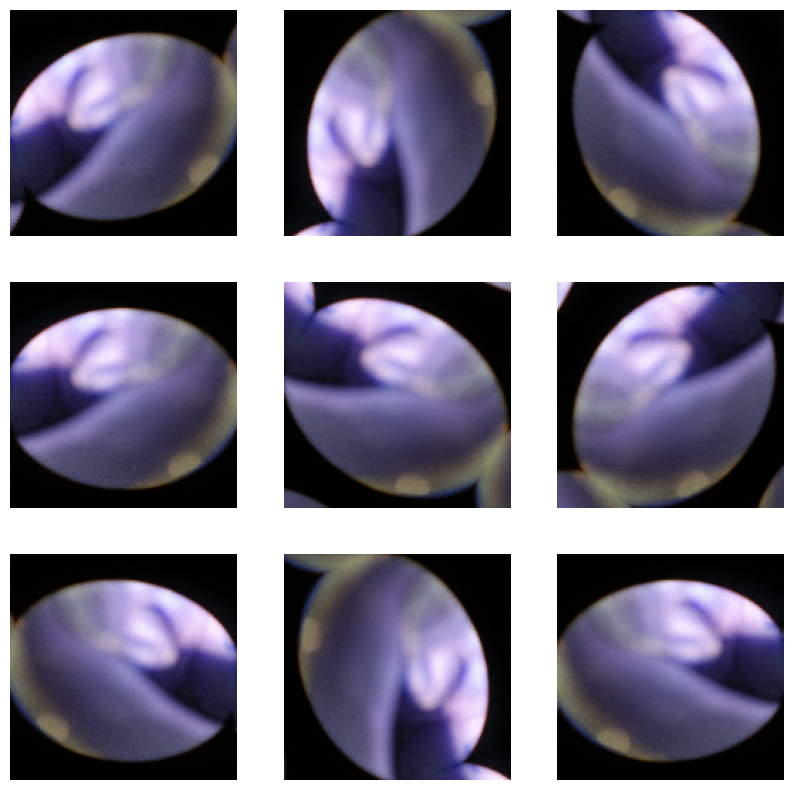

In [129]:
plt.figure(figsize=(10, 10))
first_image = train_features[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
        

# Metrics

In [130]:
def get_accuracy_metrics(model, train_features, train_labels, test_features, test_labels, val_features, val_labels):    
    test_predicted = np.argmax(model.predict(test_features),axis=1)
    val_predicted = np.argmax(model.predict(val_features), axis=1)


    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(train_labels, np.argmax(model.predict(train_features), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(val_labels, val_predicted)*100), "%")
    
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(test_labels, test_predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(test_labels, test_predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(test_labels, test_predicted)*100), "%")
    
    
    print("ROC AUC Score------------->")
    print("{0:.3f}".format(roc_auc_score(to_categorical(test_labels, num_classes = 3), test_predicted, multi_class='ovr')*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(test_labels, test_predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(test_labels, test_predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(test_labels, test_predicted)
    cf_matrix_val = confusion_matrix(val_labels, val_predicted)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

# General Model Fit

In [131]:
def learning_performance_chart(title, history):
    #plots a chart showing the change in accuracy and loss function over epochs
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    

In [132]:
def fit_model(model_name, base_model, train_features, train_labels, validate_it,training = False, epochs = EPOCHS, batch_size= BATCH_SIZE):
    
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    
    x = data_augmentation(inputs)
    x = base_model(x, training=training)
    
    if not model_name.startswith('CNN'):
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
    
    print("Model Summary.")
    
    print(model.summary())
    
    history = model.fit(x=train_features,y=train_labels ,validation_data=validate_it, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[es])

    learning_performance_chart(title="{} learning performance.".format(model_name), history=history)
    
    return model

# CNN2

In [133]:
model = tf.keras.Sequential([
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
 tf.keras.layers.Flatten(),
])

cnn2 = fit_model("CNN2", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)


Model Summary.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 3276800)           75916     
                                                                 
 dropout (Dropout)           (None, 3276800)           0         
                                                                 
 dense (Dense)               (None, 3)                 9830403   
                                                                 
Total params: 9,906,319
Trainable params: 9,906,185
Non-trainable params: 134
_________________________________________________________________
None
Epoch 1/10
148/148 [=========

KeyboardInterrupt: 

In [ ]:
print('CNN2 performance on the test set:')
get_accuracy_metrics(cnn2, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# CNN3

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Flatten(),
    ])

cnn3 = fit_model("CNN3", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)

In [ ]:
print('CNN3 performance on the test set:')
get_accuracy_metrics(cnn3, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# CNN4

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
tf.keras.layers.Flatten(),
])

cnn4 = fit_model("CNN4", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)


In [ ]:
print('CNN4 performance on the test set:')
get_accuracy_metrics(cnn4, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# CNN5

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(
        3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(
        3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(
        3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(
        3, 3), padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
])


cnn5 = fit_model("CNN5", model, train_features, train_labels_1hotenc,
                       (val_features, val_labels_1hotenc), training=True)


In [ ]:
print('CNN5 performance on the test set:')
get_accuracy_metrics(cnn5, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# CNN6

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Flatten(),
])

cnn6 = fit_model("CNN6", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)

In [ ]:
print('CNN6 performance on the test set:')
get_accuracy_metrics(cnn6, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# CNN7

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Flatten(),
])

cnn7 = fit_model("CNN7", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)

In [ ]:
print('CNN7 performance on the test set:')
get_accuracy_metrics(cnn7, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# CNN8

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Flatten(),
])

cnn8 = fit_model("CNN8", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)



In [ ]:
print('CNN8 performance on the test set:')
get_accuracy_metrics(cnn8, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# ResNet 50

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    classes=NUM_CLASSES,
)

base_model.trainable = False

resnet50 = fit_model("ResNet50", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


In [ ]:
print('ResNet50 performance on the test set:')
get_accuracy_metrics(resnet50, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

In [ ]:
vgg16 = fit_model("VGG16", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))

In [ ]:
print('VGG16 performance on the test set:')
get_accuracy_metrics(vgg16, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# VGG19 

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

In [ ]:
vgg19 = fit_model("VGG19", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))

In [ ]:
print('VGG19 performance on the test set:')
get_accuracy_metrics(vgg19, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# MobileNet Pretranined

In [ ]:
base_model = tf.keras.applications.MobileNet(include_top=False, 
                                               weights='imagenet', 
                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

In [ ]:
mobilenet = fit_model("MobileNet", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))

In [ ]:
print('MobileNet performance on the test set:')
get_accuracy_metrics(mobilenet, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# MobileNet V2 pre-trained

In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, 
                                               weights='imagenet', 
                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

In [ ]:
mobilenetv2 = fit_model("MobileNetV2", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))

In [ ]:
print('MobileNetV2 performance on the test set:')
get_accuracy_metrics(mobilenetv2, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# Inception V3

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

incpetionv3 = fit_model("InceptionV3", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


In [ ]:
print('InceptionV3 performance on the test set:')
get_accuracy_metrics(incpetionv3, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# DenseNet 121

In [ ]:
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

densenet121 = fit_model("DenseNet121", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


In [ ]:
print('DenseNet121 performance on the test set:')
get_accuracy_metrics(densenet121, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# DenseNet 169

In [ ]:
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

densenet169 = fit_model("DenseNet169", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


In [ ]:

print('DenseNet169 performance on the test set:')
get_accuracy_metrics(densenet169, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# InceptionResNetv2

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

inceptionresnetv2 = fit_model("InceptionResNetV2", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


In [ ]:
print('InceptionResNetV2 performance on the test set:')
get_accuracy_metrics(inceptionresnetv2, train_features, train_labels, test_features, test_labels, val_features, val_labels)

# ResNet101

In [ ]:
base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

resnet101 = fit_model("ResNet101", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


In [ ]:
print('ResNet101 performance on the test set:')
get_accuracy_metrics(resnet101, train_features, train_labels, test_features, test_labels, val_features, val_labels)